In [1]:
#ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [2]:
#対数収益率の正規分布を仮定した長期投資シミュレーションモデル
class asset_model:
    #初期化時の処理
    def __init__(self, mu_y, s_y):
        #パーセント表記から少数へ変換
        mu_y = mu_y / 100
        s_y = s_y / 100
        #入力された対数収益率の年次リターン・リスク（標準偏差）を月次へ変換
        self.mu_m = mu_y /12
        self.s_m = s_y / np.sqrt(12)
    
    #対数収益率の長期モンテカルロシミュレーションを実施
    def run_mc(self, dur_y, n):
        #入力された投資期間を年→月へ変換
        dur_m = dur_y * 12
        # [(試行回数),(投資期間_月)]の正規分布N(μ,σ)に従う乱数行列として毎月の対数収益率を生成
        self.A = np.random.normal(self.mu_m, self.s_m,size=[n,dur_m]) 
        
        self.dur_m = dur_m
        print("Monte Carlo Calculation of "+ str(dur_y) + " years finished")
        
    #初期投資額x_init, 毎月積立額delta_mを投資した場合の資産推移を計算
    def exercise(self, x_init, delta_m):
        #月別の投資額のリスト
        x = delta_m * np.ones(self.dur_m)
        #初期投資額を追加
        x[0] = x[0] + x_init
        
        #総資産額のリスト
        ta_list = []
        #累計投資額のリスト
        capital = [] 
        
        #総資産額の推移を1年毎(12ヶ月毎)に集計する
        for i in range(11, self.dur_m,12):
            #集計時点までの対数収益率行列を切り出し
            A_tmp = self.A[:,:i+1] 
            #集計時点までの投資額のリストを切り出し
            x_tmp = x[:i+1]
            #対数収益率行列の後ろ向き累積和（Suffix sum) 、連続複利ベースの期間終了時点の収益率を計算
            rev_cum = np.cumsum(A_tmp[:, ::-1], axis=1)
            lr_tmp = rev_cum[:, ::-1]
            #対数収益率から、価格変動比へ変換
            r_tmp = np.exp(lr_tmp)
            #各試行の、投資期間経過後の資産額を計算
            ta = np.dot(r_tmp,x_tmp)
            #計算結果を格納
            ta_list.append(ta)
            
            #累計投資額を格納
            capital.append(x_tmp.sum())
            
        #1年毎の各種統計値を計算
        #平均
        mean = np.mean(ta_list, axis=1)
        #パーセンタイル値（np.percetileは下位○%を入力するが、出力としては上位○%の表記とする）
        p10 = np.percentile(ta_list,90,axis=1)
        p25 = np.percentile(ta_list,75,axis=1)
        p50 = np.percentile(ta_list,50,axis=1)
        p75 = np.percentile(ta_list,25,axis=1)
        p90 = np.percentile(ta_list,10,axis=1)
    
        year = np.arange(self.dur_m/12)+1
        
        #計算結果をDataFrameに格納
        df_result = pd.DataFrame(np.transpose([year,mean,p10,p25,p50,p75,p90,capital]),columns=["Year","Mean","P10","P25","P50","P75","P90","Capital"])
        pd.options.display.float_format = '{:.1f}'.format
        display(df_result)
            
        #グラフ出力
        left, width = 0.1, 0.65 
        bottom, height = 0.1, 0.65 
        fig_main = [left, bottom, width, height] #散布図の定義
        fig =plt.figure(figsize=(10,7)) 
        ax = fig.add_axes(fig_main)

        ax.fill_between(df_result["Year"],df_result["P10"],df_result["P90"], alpha=0.3, label="Range P10-P90")
        ax.fill_between(df_result["Year"],df_result["P25"],df_result["P75"], alpha=0.3, label="Range P25-P75")
        ax.plot(df_result["Year"],df_result["P50"], label="P50")
        ax.plot(df_result["Year"], df_result["Capital"], label="Capital")
        ax.set_ylim(0, max(df_result["P10"])*1.1)
        ax.set_xlim(1,max(df_result["Year"]))
        ax.set_xlabel("Year")
        ax.set_ylabel("Total assets")
        ax.grid(True)
        ax.legend()    
        

Monte Carlo Calculation of 10 years finished


,Year,Mean,P10,P25,P50,P75,P90,Capital
0,1.0,126.7,147.6,136.7,125.6,115.6,107.4,120.0
1,2.0,266.7,328.0,294.5,262.1,234.0,211.3,240.0
2,3.0,421.4,540.8,474.5,410.4,356.6,315.7,360.0
3,4.0,592.1,787.1,675.2,571.9,486.3,421.6,480.0
4,5.0,781.1,1072.5,901.3,747.8,622.7,530.8,600.0
5,6.0,989.4,1396.5,1154.3,936.1,766.9,646.0,720.0
6,7.0,1219.1,1768.0,1432.4,1142.3,918.9,763.0,840.0
7,8.0,1473.9,2190.5,1745.2,1365.8,1081.8,886.0,960.0
8,9.0,1756.0,2669.4,2096.1,1614.2,1256.2,1012.9,1080.0
9,10.0,2068.3,3218.3,2480.0,1882.9,1439.6,1143.8,1200.0


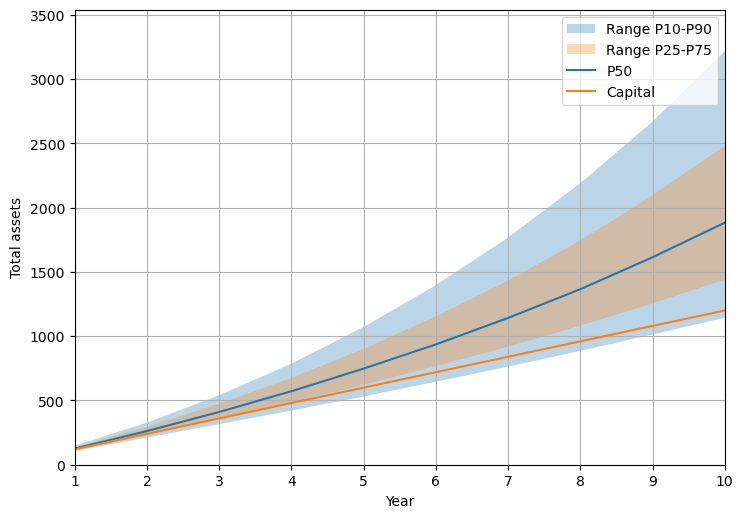

In [3]:
# 期待対数収益率、標準偏差（%,年換算）
mu = 8
s = 20

#リターンmu、リスクsのモデルを定義
model = asset_model(mu,s)

# 投資期間（年）
dur_y = 10
# 試行回数
n = 100000

#投資期間dur_y、試行回数nのモンテカルロシミュレーションを実行
model.run_mc(dur_y,n)

# 初期投資額
x_init = 0
# 毎月積立額
delta_m = 10

#初期投資x_init、毎月delta_mの積立投資を行った場合の資産推移を計算
model.exercise(x_init,delta_m)

,Year,Mean,P10,P25,P50,P75,P90,Capital
0,1.0,1326.4,1679.8,1487.5,1299.6,1136.0,1006.4,1200.0
1,2.0,1464.9,2022.9,1701.8,1406.9,1164.7,978.4,1200.0
2,3.0,1618.5,2374.1,1926.8,1523.7,1206.7,977.7,1200.0
3,4.0,1787.3,2747.8,2165.4,1650.6,1258.9,988.9,1200.0
4,5.0,1975.4,3168.5,2414.6,1788.4,1322.2,1007.0,1200.0
5,6.0,2182.5,3625.1,2692.6,1935.9,1392.2,1033.4,1200.0
6,7.0,2409.8,4126.8,2989.1,2092.8,1467.3,1065.1,1200.0
7,8.0,2663.0,4690.1,3323.4,2266.1,1551.2,1100.0,1200.0
8,9.0,2944.2,5307.9,3685.7,2456.3,1642.5,1141.9,1200.0
9,10.0,3255.3,6009.2,4076.2,2663.1,1736.8,1183.8,1200.0


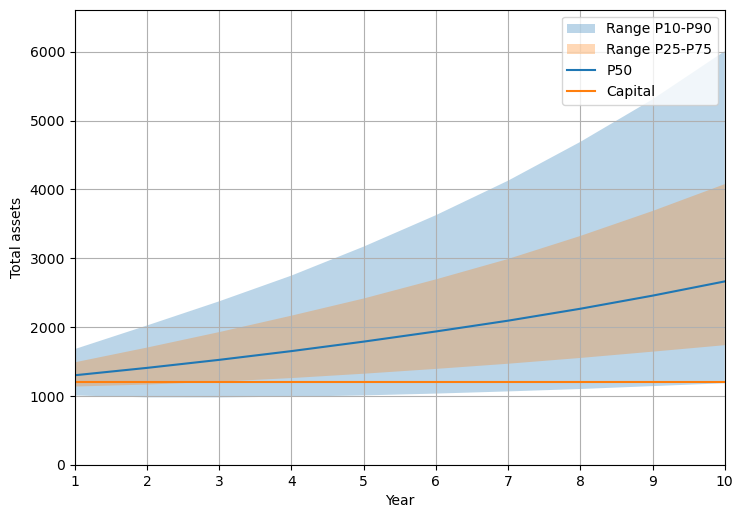

In [4]:
# 初期投資額
x_init = 1200
# 毎月積立額
delta_m = 0

#初期投資x_init、毎月delta_mの積立投資を行った場合の資産推移を計算
model.exercise(x_init,delta_m)

以下、コード説明用

In [6]:
#print出力のフォーマット調整
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=100)

In [7]:
dur_m = 1 * 12
mu_m = 0.09 / 12
s_m = 0.20 / np.sqrt(12)
n = 5
#ランダムシード固定（デバッグ用）
np.random.seed(1)
A = np.random.normal(mu_m,s_m,size=[n,dur_m])
print(np.shape(A))
print(A)

(5, 12)
[[ 0.101 -0.028 -0.023 -0.054  0.057 -0.125  0.108 -0.036  0.026 -0.007  0.092 -0.111]
 [-0.011 -0.015  0.073 -0.056 -0.002 -0.043  0.01   0.041 -0.056  0.074  0.06   0.037]
 [ 0.06  -0.032  0.    -0.047 -0.008  0.038 -0.032 -0.015 -0.032 -0.041 -0.031  0.007]
 [-0.057  0.021  0.103  0.05  -0.004 -0.044 -0.036  0.105  0.01  -0.029  0.019  0.129]
 [ 0.014  0.043  0.025 -0.013 -0.058 -0.013 -0.005  0.041  0.056  0.061  0.024  0.059]]


In [8]:
rev_cum = np.cumsum(A[:, ::-1], axis=1)
lr = rev_cum[:, ::-1]
print(np.shape(lr))
print(lr)

(5, 12)
[[-0.001 -0.102 -0.074 -0.051  0.003 -0.054  0.071 -0.037 -0.001 -0.026 -0.02  -0.111]
 [ 0.11   0.121  0.136  0.063  0.119  0.122  0.165  0.155  0.114  0.17   0.096  0.037]
 [-0.134 -0.194 -0.162 -0.162 -0.116 -0.108 -0.146 -0.113 -0.098 -0.066 -0.024  0.007]
 [ 0.268  0.325  0.304  0.201  0.151  0.154  0.198  0.234  0.128  0.118  0.147  0.129]
 [ 0.235  0.221  0.177  0.153  0.165  0.224  0.237  0.241  0.2    0.144  0.083  0.059]]


In [10]:
r = np.exp(lr)
print(np.shape(r))
print(r)

(5, 12)
[[0.999 0.903 0.929 0.95  1.003 0.947 1.074 0.964 0.999 0.974 0.981 0.895]
 [1.117 1.129 1.146 1.065 1.126 1.129 1.179 1.167 1.12  1.185 1.101 1.037]
 [0.874 0.824 0.851 0.85  0.891 0.898 0.864 0.893 0.907 0.936 0.976 1.007]
 [1.308 1.385 1.356 1.223 1.163 1.167 1.219 1.263 1.137 1.125 1.159 1.137]
 [1.265 1.247 1.194 1.165 1.18  1.251 1.267 1.273 1.221 1.155 1.086 1.06 ]]


In [12]:
x = np.ones(12)
ta = np.dot(r,x)
print(np.shape(ta))
print(ta)

(5,)
[11.618 13.502 10.771 14.641 14.364]
